In [812]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Timeseries

from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#FBprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

# Connect to SQL database
import sqlite3

In [1319]:
# Import table
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()
df = pd.read_sql_query("SELECT * FROM df_clean", connex)
cur.close()

In [1320]:
ts = df.copy(deep = False) # Different manipulation for TimeSeries
ts['date_hour'] = pd.to_datetime(ts['date_hour'])
ts = ts.set_index('date_hour')

### Random Forest for regressor selection in SARIMAX 

In [155]:
df.date_hour = pd.to_datetime(df.date_hour)
df['hour'] = df.date_hour.dt.hour
df['month'] = df.date_hour.dt.month

In [1189]:
ts['is_holiday'].head()

date_hour
2018-04-11 00:00:00    0
2018-04-11 01:00:00    0
2018-04-11 02:00:00    0
2018-04-11 03:00:00    0
2018-04-11 04:00:00    0
Name: is_holiday, dtype: int64

In [109]:
def create_dummies(col_names, df):
    """
    Returns Dataframe after creating dummy variables for all columns mentioned in col_names list
    for the dataframe df
    """
    for col in col_names:
        dummy = pd.get_dummies(df[col], prefix = f'{col}')
        df.drop([col], axis = 1 , inplace = True)
        df = pd.concat([df,dummy] , axis = 1)
    return df

In [161]:
# df = create_dummies(['condition','day_ind','is_weekend','is_holiday','month','hour'], df)


In [157]:
df = df.drop(['date_hour'],axis = 1)

In [163]:
X = df.drop(['bixi_rentals'], axis = 1)
y = df[['bixi_rentals']]

In [164]:
#split our data into a test and train set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [165]:
rf = RandomForestClassifier(criterion = 'gini', max_depth = 14, n_estimators = 150)
rf.fit(X_train, y_train)

/Users/pacman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [166]:
y_train_hat = rf.predict(X_train)
y_test_hat = rf.predict(X_test)

In [167]:
# Residuals
resid = pd.DataFrame(abs(y_train.values.flatten() - y_train_hat), columns=['residual'])

In [168]:
resid[resid['residual'] != 0].sort_values(by = 'residual', ascending = False).head(10)

,residual
2193,1048
1511,1017
792,916
1961,845
3653,836
1711,756
3719,742
198,673
2016,624
2490,608


In [169]:
r2_score(y_train.values.flatten(), y_train_hat)

0.997354195415717

In [170]:
r2_score(y_test.values.flatten(), y_test_hat)

0.6485180542966866

In [143]:
mean_squared_error(y_train.values.flatten(), y_train_hat)

585.3036311514572

In [144]:
mean_squared_error(y_test.values.flatten(), y_test_hat)

135436.37917860554

In [ ]:
# Grid Search
param_grid_rf = {'criterion' : ['gini','entropy'],
                 'max_depth': [5,10],
                 'n_estimators': [100, 115, 150]}
In [86]:
# Instantiating Random Forest classifier 
forest = RandomForestClassifier()
grid_rf = GridSearchCV(forest, param_grid = param_grid_rf) # default cv = 3
grid_rf.fit(X_train, y_train)

In [172]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(13,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), list(X.columns)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

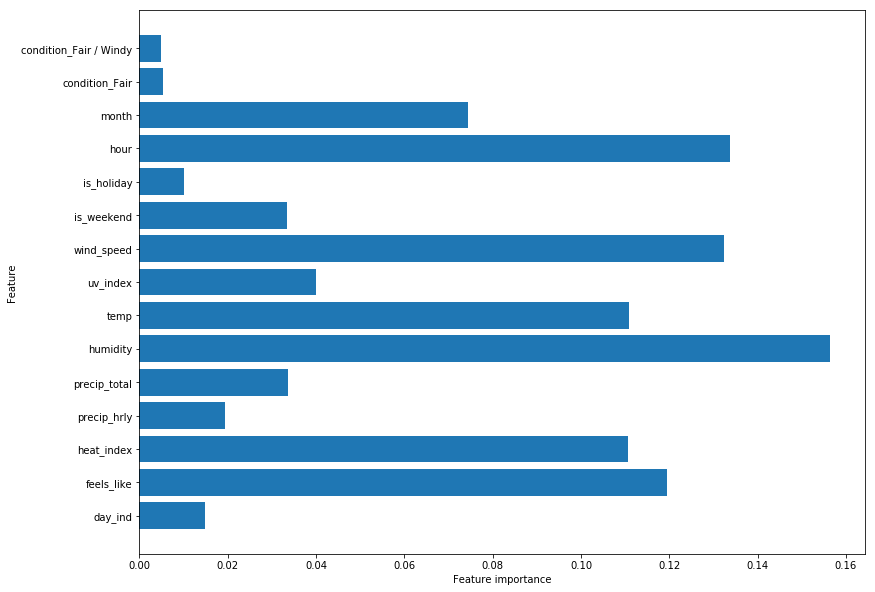

In [173]:
plot_feature_importances(rf)

### Time Series analysis

In [518]:
X = ts[['humidity','feels_like','precip_hrly']]
y = ts[['bixi_rentals']]

In [393]:
# Seasonality seems to be present as patterns seem to repeat every 7 days.
# It makes sense to compare the same day of the week at the same hour to remove seasonality.

def stationarity_check(df, window = 24):
    
    rcParams['figure.figsize'] = 18, 8
    rolmean = df.dropna().rolling(window = window).mean()
    rolstd = df.rolling(window = window, center = False).std()
    
    fig = plt.figure(figsize=(18,8))
    orig = plt.plot(df.dropna(), color='teal',label='Original', alpha = 0.25)
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    decomp = seasonal_decompose(df.dropna(), model='additive', freq=24) # Repetition every week
    ax = decomp.plot()
    plt.show
    
    X = df.dropna().values.flatten()
    result = adfuller(X)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

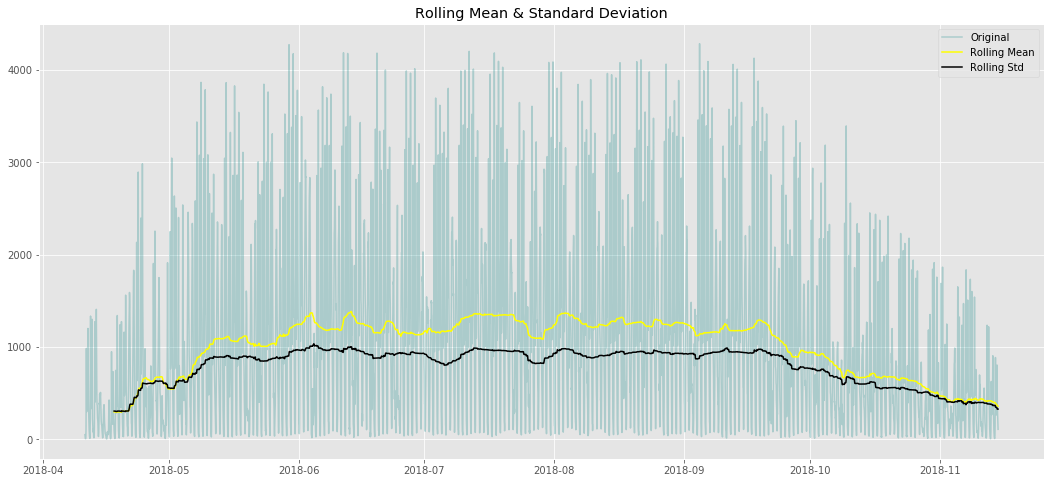

ADF Statistic: -5.604657
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


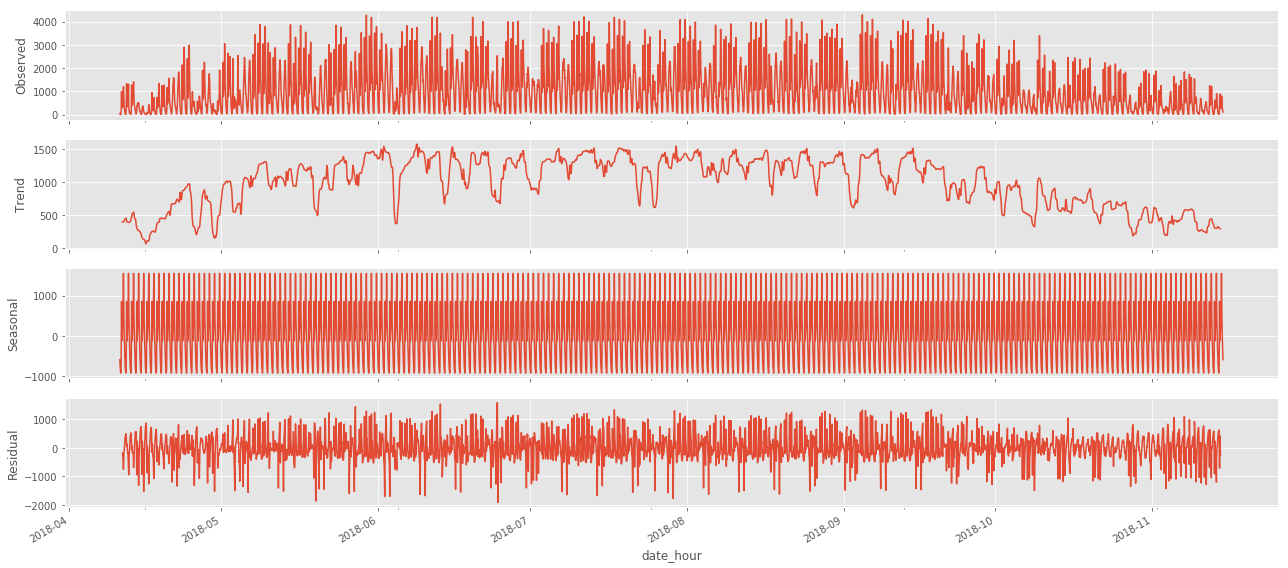

In [312]:
stationarity_check(y, 168)

### Decomposition + Base Model

In [519]:
y_shift = y - y.shift(168)
y_shift.dropna(inplace = True)

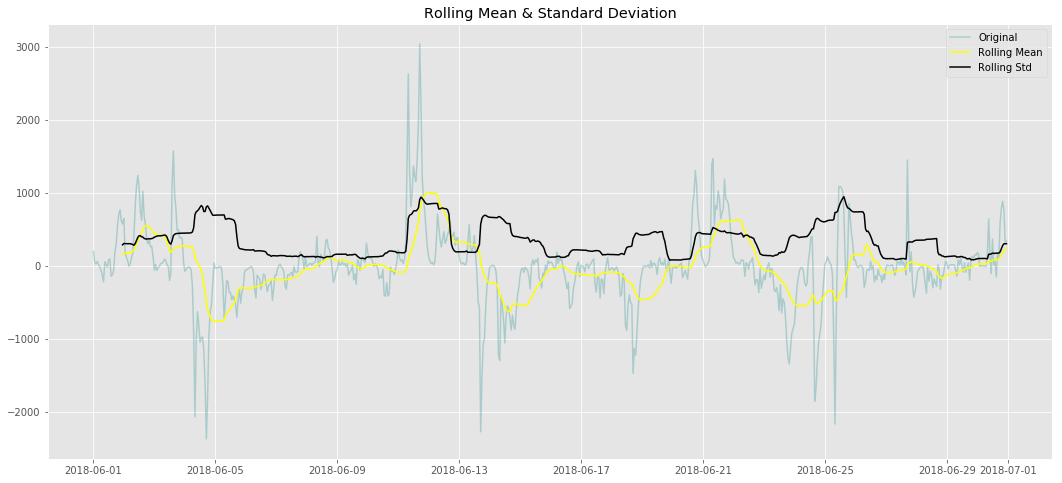

ADF Statistic: -4.064736
p-value: 0.001107
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


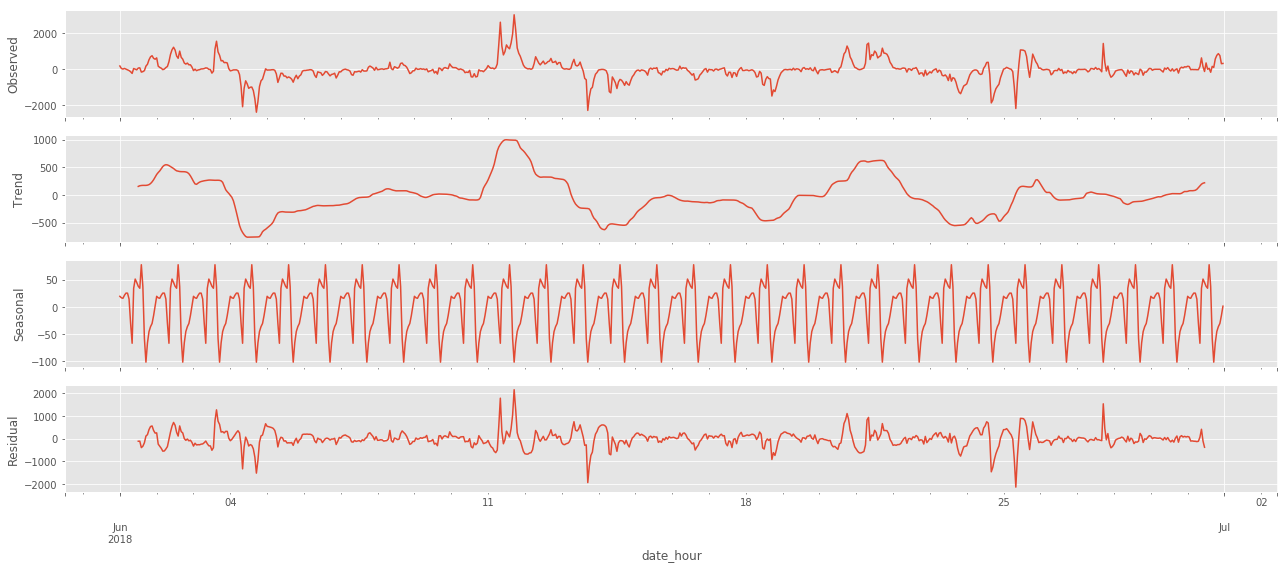

In [432]:
stationarity_check(y_shift['06-2018'])

<function matplotlib.pyplot.show(*args, **kw)>

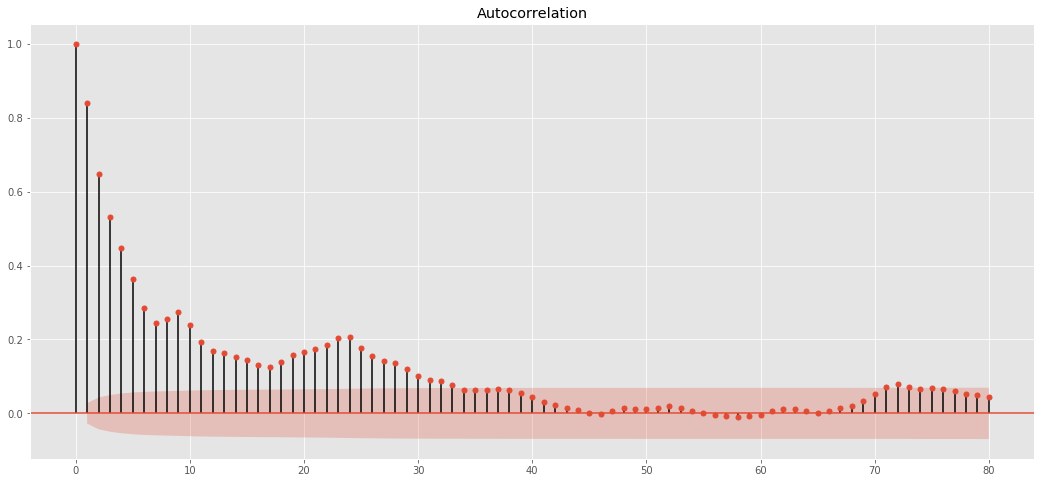

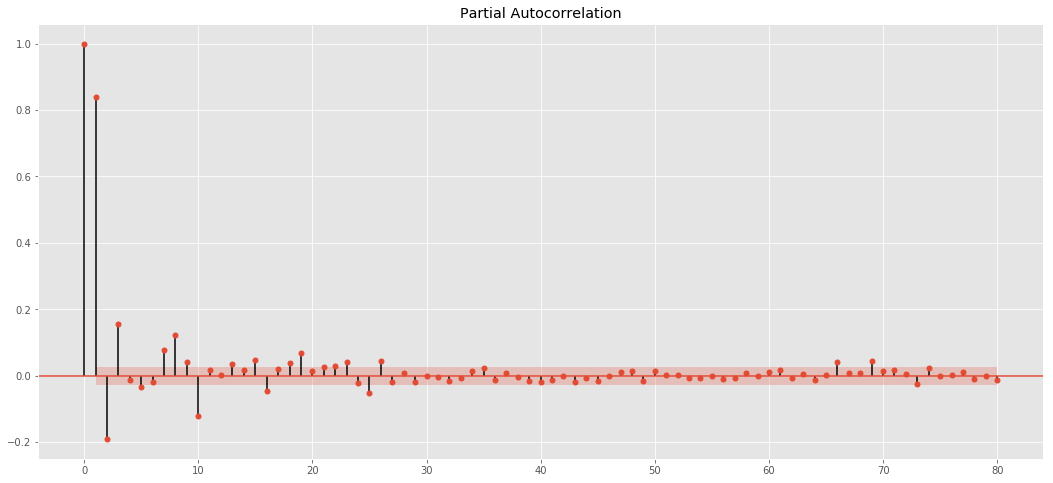

In [396]:
ax = plot_acf(y_shift, lags = 80)
ax = plot_pacf(y_shift, lags = 80, method='ywm')
plt.show

In [520]:
X_shift = X[168:] # No need to substract values from one week before for the weather

y_train, y_test = y_shift[:4052], y_shift[4052:] # Autoregression
X_train, X_test = X_shift[:4052], X_shift[4052:] # Exogenous variables

In [528]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(
    endog = y_shift,
    exog = X_shift,
    order=(1,0,2),
    seasonal_order=(1,0,2,24),
    enforce_stationarity=False,
    enforce_invertibility=False)


output = mod.fit()
output.summary()

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

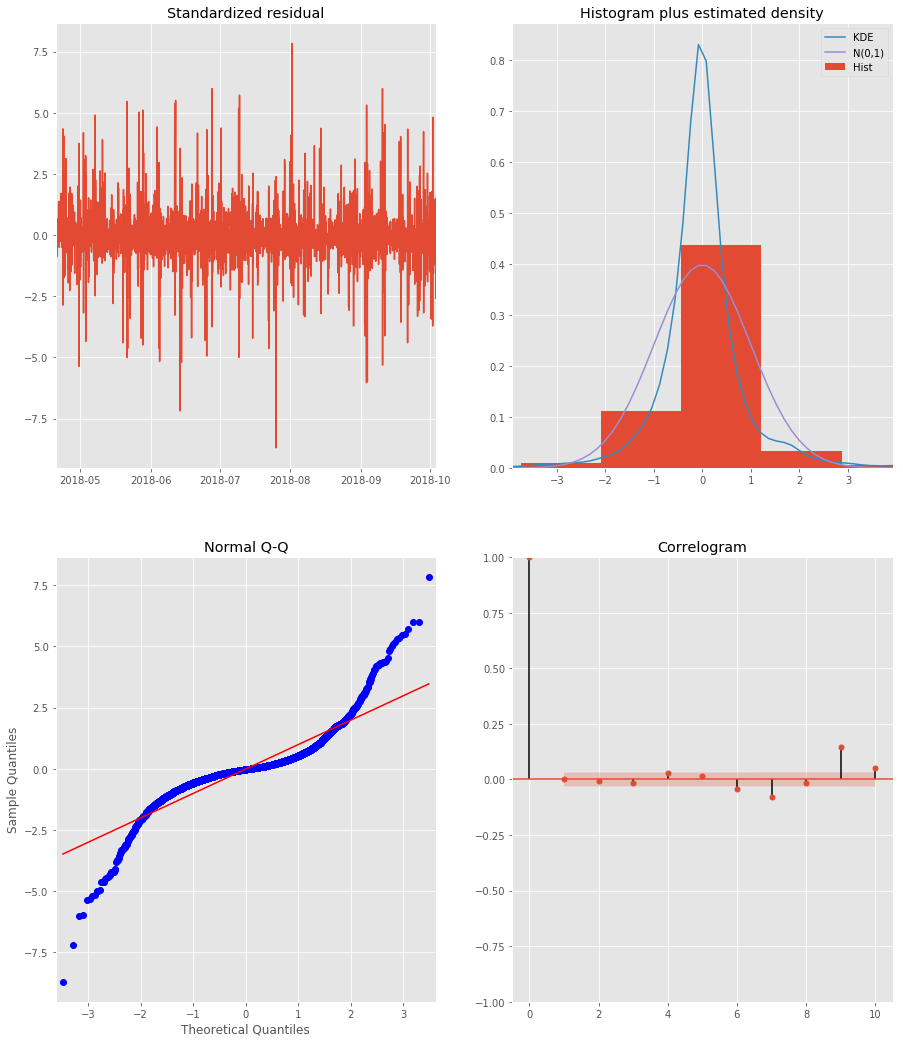

In [472]:
output.plot_diagnostics(figsize=(15, 18));

In [512]:
pred = output.get_prediction(start = 4052, dynamic=False, alpha =  0.05)
pred_conf = pred.conf_int()

ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

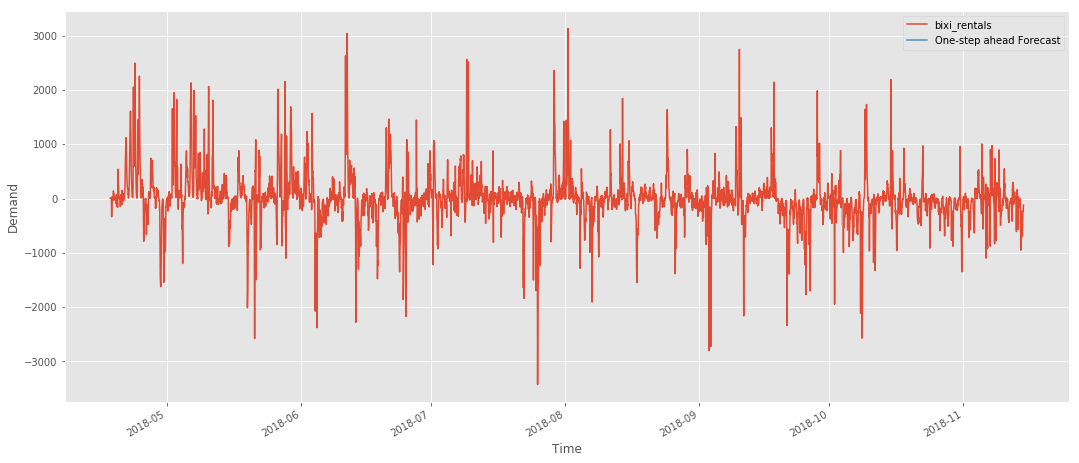

In [508]:
# rcParams['figure.figsize'] = 20,12

#Plot observed values
ax = y_shift.plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Time')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [509]:
# Get the Real and predicted values
forecast = pred.predicted_mean.values
real = y_shift.values.flatten()

# RMSE
print('The Root Mean Squared Error of forecast is {}'.format(np.sqrt(mean_squared_error(forecast,real))))
print('R2 score is {}'.format(r2_score(forecast,real)))

ValueError: Found input variables with inconsistent numbers of samples: [1, 5065]

In [ ]:
# SARIMAX(1, 0, 1)x(0, 1, 1, 24) - AIC:72999.18045610248 - best so far with X
# SARIMAX(1, 0, 1)x(1, 1, 1, 24) - AIC 72454.686 - best so far 
# SARIMAX(1, 0, 1)x(2, 0, 1, 24) - AIC:69381.4435911726 - best so far (with X)
# SARIMAX(1, 0, 2)x(1, 0, 2, 24) - AIC:69362.10998913953 - best ..

In [420]:
import itertools

p = list(range(1,3))
d = [0]
q = list(range(1,3))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]


In [422]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog= y_shift,
                                            exog= X[168:],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 24) - AIC:69666.55412383129


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 2, 24) - AIC:69530.18784715844


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 24) - AIC:69381.4435911726


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 24) - AIC:69581.75530568213


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 1, 24) - AIC:69709.40193960424


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 24) - AIC:69362.10998913953


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 24) - AIC:69558.04079628995


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 24) - AIC:69534.31397560464


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 24) - AIC:69875.53191737222


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 24) - AIC:69545.69111982515


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 24) - AIC:69561.21977367112


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 24) - AIC:69562.8042732034


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 1, 24) - AIC:69843.82289259224


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 24) - AIC:69529.9734403397


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 24) - AIC:69543.57562015642


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 24) - AIC:69532.5332278152


### FB Prophet

Contrarly to ARIMA and SARIMAX models, FBProphet is framed as a "curve-fitting" problem rather than a time-dependency problem. It is an additive regression model.

With FB Prophet, it is possible to have multiple seasonalities, for daily and weekly in this case. Each seasonality component is estimated using a tunable parameter for the Fourier order. Increasing the Fourier order allows for additional waves into the model, meaning that the seasonality curve is allowed to change more quickly.

For each timestamp (t), the model predicts a value y(t) represented by the sum of the trend component, the seasonality s(t) component that accounts for periodic changes (daily & weekly for Bixi), a holiday h(t) component plus an error term which is assumed to be normally distributed.

> $y(t) = g(t) + s(t) + h(t) + \epsilon_t$

The model I used includes exogenous variables as well to explain variability.

> $y(t) = g(t) + s(t) + h(t) + \beta *  \epsilon_t$

In [1327]:
ts_fb = y.reset_index().rename(columns = {'date_hour': 'ds', "bixi_rentals": "y"})

In [1328]:
ts_fb['heat_index'] = df['heat_index']
# ts_fb['precip_hrly'] = df['precip_hrly']
ts_fb['precip_total'] = df['precip_total']
ts_fb['humidity'] = df['humidity']
ts_fb['wind_speed'] = df['wind_speed']
ts_fb['holiday'] = df['is_holiday']
ts_fb.tail()

,ds,y,heat_index,precip_total,humidity,wind_speed,holiday
5228,2018-11-14 19:00:00,355,17.0,1.0,57.0,9.0,0
5229,2018-11-14 20:00:00,290,17.0,1.0,55.0,8.0,0
5230,2018-11-14 21:00:00,236,16.0,1.0,55.0,7.0,0
5231,2018-11-14 22:00:00,156,16.0,1.0,57.0,6.0,0
5232,2018-11-14 23:00:00,108,15.0,1.0,63.0,7.0,0


In [1011]:
holidays = ts_fb[['ds','holiday']]
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5233 entries, 0 to 5232
Data columns (total 2 columns):
ds         5233 non-null datetime64[ns]
holiday    5233 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 81.8 KB


### Metrics : RMSE, R2

- **RMSE** will be used as the main metric to choose the best model as it is the most interpretable and can be translated into the average number of bikes the model is off by. It measures the square root of the average sum of squared residuals of the model. 
> RMSE = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_j-\hat{y_j})^{2}}$

- **R2** will be used as a second metric if models show a similar RMSE. R2 measures the variance explained by the model in comparison to the total variance.

In [1506]:
def rmse(forecast, ts):
    """
    Function takes in 2 dataframes: forecast from FB Prophet and Timeseries (ts) containing actual values and
    returns DataFrame with actual, real, error values as columns and Root mean square error (RMSE).
    """

    df = forecast[['ds','yhat']].rename(columns = {'ds': 'date_hour'})
    df['date_hour'] = pd.to_datetime(df['date_hour'])
    df = df.set_index('date_hour')
    
    # Merge on index, by default merge takes inner join
    df = pd.merge(df, ts, left_index=True, right_index=True)[['yhat', 'bixi_rentals']]
    
    # Calculate RMSE
    RMSE = np.sqrt(mean_squared_error(df['yhat'],df['bixi_rentals']))
    
    R2 = r2_score(df['yhat'],df['bixi_rentals'])
    
    results = print(f'RMSE: {RMSE} ; R2: {R2}')
    
    return df, results

In [1540]:
def fit_predict(ts_fb, train_obs, include_history = False, c = 0.15):
    
    """
    
    Takes in dataframe with columns ds, y for target variable, eXogenous variables as first argument (ts_fb)
    and  as second argument (train_obs). Returns model (m) and forecast using 
    the rest of the observations to test.
    
    :param ts_fb: dataframe with columns ds, y containting target variables, eXogenous variables
    :param train_obs: number of training observations
    :param include_history: if set to true, predicts all values; if set to false, trains and test
    :param c: number of training observations
    
    :returns: model and dataframe with forecast using the out of sample observations for testing
    """    
    m = Prophet(yearly_seasonality=False,
                daily_seasonality= 24,          
                weekly_seasonality=52,
                interval_width=0.95,
                changepoint_prior_scale= c)   # change_prior_scale decreased to make the trend less flexible

    m.add_regressor('heat_index')
    m.add_regressor('precip_total')
    m.add_regressor('humidity')
    m.add_regressor('wind_speed')
    m.add_country_holidays(country_name='Canada')
    
    # Train model up to train_obs' index
    m.fit(ts_fb[:train_obs])  

    
    future = m.make_future_dataframe(periods=(ts_fb.shape[0] - train_obs),
                                     freq = 'H',
                                     include_history = include_history)
    
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
    
    elif include_history == False:
        
        # forecast will return prediction for test set with exogenous variables
        
        # Adding Exogenous variables to future dataframe needed to predict y
        future['heat_index'] = ts_fb.heat_index[train_obs:].reset_index().drop(['index'],axis = 1)
        future['precip_total'] = ts_fb.precip_total[train_obs:].reset_index().drop(['index'],axis = 1)
        future['humidity'] = ts_fb.humidity[train_obs:].reset_index().drop(['index'],axis = 1)
        future['wind_speed'] = ts_fb.wind_speed[train_obs:].reset_index().drop(['index'],axis = 1)

        # Test model starting at last observation from train_obs
        forecast = m.predict(future)
    
    else:
        # forecast will return prediction for training set with exogenous variables      
        
        forecast = m.predict(ts_fb[:train_obs])
 
    return m, forecast

The best model so far seems to overfit the training set as it seems to learn the noise rather than the signal.

In [1541]:
m_train, forecast_train = fit_predict(ts_fb.drop(['holiday'],axis =1), train_obs=3500, include_history = True)
# rmse(forecast_train,y)[1]

In [1523]:
m_test, forecast_test = fit_predict(ts_fb.drop(['holiday'],axis =1), train_obs=3500, include_history = False)
rmse(forecast_test,y)[1]

RMSE: 393.9343539291156 ; R2: 0.7492656956024277


In [1537]:
# GridSearch for ChangePoint parameter
def tuning_changepoint_prior_scale(min_c = 0.13, max_c = 0.20, step_c = 1, train_obs):
    """
    Function to GridSearch optimal value of changepoint_prior_scale.
    
    :param min_c: this is a first param
    :param max_c: this is a second param
    :param step_c: this is a second param
    :param train_obs: number of training observations
    
    :returns: RMSE and R2 for each value of c
    """
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
        
    for c in list(np.linspace(min_c,max_c,step_c)):
        m_test, forecast_test = fit_predict(ts_fb.drop(['holiday'],axis =1),
                                            train_obs=train_obs,
                                            include_history = False,
                                            c = c)
        print(f'c = {c}')
        rmse(forecast_test,y)[1]
        print(f'\n')

In [1538]:
tuning_changepoint

/Users/pacman/anaconda3/lib/python3.7/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


KeyboardInterrupt: 

In [ ]:
dodo = df_test.reset_index()
dodo['error'] = (dodo['yhat'] - dodo['bixi_rentals'])
ax = dodo.plot(x = 'date_hour', figsize = (19,8), title = 'Predictions, Actual Values and errors')

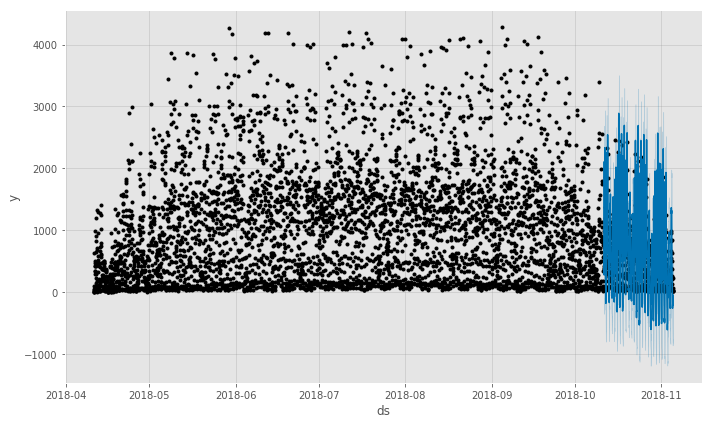

In [1450]:
fig1 = m.plot(forecast[-600:])



## Algo options

#### Deep Learning - because of weather or event in the city that will hike up the demand